In [2]:
import astropy.io.fits as fits
import numpy as np
import random
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft
import theano.tensor.signal.conv

Enter the timescale of variation for the driving function(ℓ_true=2*ℓ^2)[d^(1/2)]: 0.7
Enter the long term standard deviation for the driving function[mag]: 0.3
Enter the exponent related to the PSD slope (alpha): 1.0
time values are saved as "X" and magnitude values are saved as "f_true"


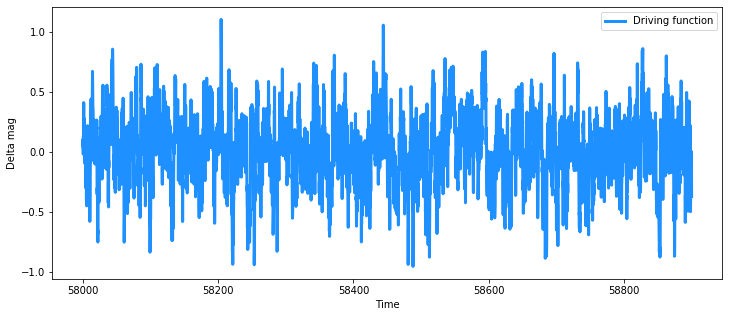

In [3]:
# set the seed
np.random.seed(42)

n = 5000
 # The number of data points
#ntau=10000.0 number of points for transfer function 
tau = np.linspace(0.0, 60.0, n)#delay times for transfer function 
start = 58000
end = 58900
X = np.linspace(start, end, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = float(input("Enter the timescale of variation for the driving function(ℓ_true=2*ℓ^2)[d^(1/2)]: "))#timescale of variation for the driving function
#REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
η_true = float(input("Enter the long term standard deviation for the driving function[mag]: "))#long term standard deviation for the driving function
α_true = float(input("Enter the exponent related to the PSD slope (alpha): "))#exponent related to the PSD slope 
np.savetxt('hyperparameters.txt',np.c_[ℓ_true,η_true,α_true],delimiter=',')
#cov_func = η_true**2 * pm.gp.cov.Exponential(1, 2.0**((α_true-1.0)/2.0)*ℓ_true**(α_true))
cov_func = η_true**2 * pm.gp.cov.Exponential(1, ls=ℓ_true)
# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),cov_func(X).eval() , 1).flatten()
np.savetxt('drivingfunction.txt',np.c_[X,f_true],delimiter=',')
# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
#σ_true = 2.0
#ν_true = 3.0
#y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="Driving function");
#ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("Time"); ax.set_ylabel("Delta mag"); plt.legend();
print('time values are saved as "X" and magnitude values are saved as "f_true"')

In [4]:
def transferDT(wav, pDT, tau):
    sigma_DT, m_DT, theta_DT, T = pDT

    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = 4.967#h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    where_are_NaNs1 = np.isnan(lognorm_DT)
    lognorm_DT[where_are_NaNs1] = 0.0
    
    #Dusty Torus transfer equation for band
    b = h*c/(1e-9*wav*k*T)
    BB = (1.0/( wav**5 * (np.exp(b) - 1.0) ))/BB_max
    Psi_DT = BB*lognorm_DT
    
    return Psi_DT
    
def transferAD(wav, K_0, index, pAD, tau):
    sigma_AD, m_AD, theta_AD = pAD
    
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    
    #Accretion Disk transfer equation for the band
    powr = K_0*(wav/wav_0)**(index)    
    exp_AD = -((np.log((tau-theta_AD)/m_AD))**2/(2*sigma_AD**2))
    front_AD = 1.0/((tau-theta_AD)*sigma_AD*np.sqrt(2*np.pi))
    lognorm_AD = front_AD*np.exp(exp_AD)
    where_are_NaNs2 = np.isnan(lognorm_AD)
    lognorm_AD[where_are_NaNs2] = 0.0
    Psi_AD = powr*lognorm_AD

    return Psi_AD

#Function to convolve driving function with transfer function to obtain data
def createdata(f_true, tau, wav, K_0, index, pDT, pAD, noise_scale):
    Psi_tot = transferDT(wav, pDT, tau) + transferAD(wav, K_0, index, pAD, tau)
    data = np.convolve(f_true,Psi_tot,'same')
    uncer = np.random.rand(len(f_true))*noise_scale
    return [data,uncer]

In [9]:
a = input("Are you lazy (yes/no)?: ")
if a == "yes":
    # create data for all bands
    pDT = [0.4,12.0,47.0,1456.0]# sigma_DT, m_DT, theta_DT, T
    K_0 = 1.0# Power law consant
    index = 1.5# Power slope index
    k = 1.0# Noise boost factor
    # Saves the universal parameters for the dusty torus, power law and noise boost factor
    np.savetxt('Universalparameters.txt',np.concatenate([pDT,[K_0],[index],[k]]),delimiter=',')
    
    Jwav = 1250.0 # Wavelength in nm 
    JpAD = [1.80,24.62,0.0]# Parameters sigma_AD, m_AD, theta_AD
    Jnoisescale = 0.1/k
    Jband = createdata(f_true, tau, Jwav, K_0, index, pDT, JpAD, Jnoisescale)
    np.savetxt('Jband.txt',np.c_[Jband[0],Jband[1]],delimiter=',')
    
    Hwav = 1625.0
    HpAD = [1.57,26.61,0.0]
    Hnoisescale = 0.1/k
    Hband = createdata(f_true, tau, Hwav, K_0, index, pDT, HpAD,Hnoisescale)
    np.savetxt('Hband.txt',np.c_[Hband[0],Hband[1]],delimiter=',')
    
    Kwav = 2150.0
    KpAD = [1.23,28.66,0.0]
    Knoisescale = 0.1/k
    Kband = createdata(f_true, tau, Kwav, K_0, index, pDT, KpAD, Knoisescale)
    np.savetxt('Kband.txt',np.c_[Kband[0],Kband[1]],delimiter=',')
    
    gwav = 475.4
    gpAD = [2.4,11.68,0.0]
    gnoisescale = 0.1/k
    gband = createdata(f_true, tau, gwav, K_0, index, pDT, gpAD,gnoisescale)
    np.savetxt('gband.txt',np.c_[gband[0],gband[1]],delimiter=',')
    
    rwav = 620.4
    rpAD = [2.31,14.34,0.0]
    rnoisescale = 0.1/k
    rband = createdata(f_true, tau, rwav, K_0, index, pDT, rpAD, rnoisescale)
    np.savetxt('rband.txt',np.c_[rband[0],rband[1]],delimiter=',')
    
    iwav = 769.8
    ipAD = [2.18,17.13,0.0]
    inoisescale = 0.1/k
    iband = createdata(f_true, tau, iwav, K_0, index, pDT, ipAD, inoisescale)
    np.savetxt('iband.txt',np.c_[iband[0],iband[1]],delimiter=',')
    
    zwav = 966.5
    zpAD = [1.99,22.55,0.0]
    znoisescale = 0.1/k
    zband = createdata(f_true, tau, zwav, K_0, index, pDT, zpAD, znoisescale)
    np.savetxt('zband.txt',np.c_[zband[0],zband[1]],delimiter=',')
    
    # Saves all the accretion disk paramters
    np.savetxt('ADparameters.txt',np.c_[JpAD,HpAD,KpAD,gpAD,rpAD,ipAD,zpAD],delimiter=',')
    print('Data is saved under "*band.txt" where * is the band. They are ordered as follow: [*-band delta mag, *-band delta mag error]')
    print('Dusty torus paramters are saved under "Universalparameters.txt".')
    print('Accretion disk paramters are saved under "ADparameters.txt".')
elif a == "no":
    #create data for all bands
    pDT = list(map(float,input('Enter the universal dusty torus values;sigma_DT[log(d)] m_DT[d] theta_DT[d] T[K]: ').split()))
    K_0 = float(input("Enter the power law constant K_0: "))
    index = float(input("Enter the power law index: "))
    k = float(input("Enter the noise boost factor k: "))
    #Saves the universal parameters for the dusty torus, power law and noise boost factor
    np.savetxt('Universalparameters.txt',np.concatenate([pDT,[K_0],[index],[k]]),delimiter=',')
    
    Jwav = float(input("Enter the J-band wavelength[nm]: "))
    JpAD = list(map(float,input('Enter J-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
    Jnoisescale = float(input("Enter the noise scale: "))/k
    Jband = createdata(f_true, tau, Jwav, K_0, index, pDT, JpAD, Jnoisescale)
    np.savetxt('Jband.txt',np.c_[Jband[0],Jband[1]],delimiter=',')
    
    Hwav = float(input("Enter the H-band wavelength[nm]: "))
    HpAD = list(map(float,input('Enter H-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
    Hnoisescale = float(input("Enter the noise scale: "))/k
    Hband = createdata(f_true, tau, Hwav, K_0, index, pDT, HpAD,Hnoisescale)
    np.savetxt('Hband.txt',np.c_[Hband[0],Hband[1]],delimiter=',')
    
    Kwav = float(input("Enter the K-band wavelength[nm]: "))
    KpAD = list(map(float,input('Enter K-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
    Knoisescale = float(input("Enter the noise scale: "))/k
    Kband = createdata(f_true, tau, Kwav, K_0, index, pDT, KpAD, Knoisescale)
    np.savetxt('Kband.txt',np.c_[Kband[0],Kband[1]],delimiter=',')
    
    gwav = float(input("Enter the g-band wavelength[nm]: "))
    gpAD = list(map(float,input('Enter g-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
    gnoisescale = float(input("Enter the noise scale: "))/k
    gband = createdata(f_true, tau, gwav, K_0, index, pDT, gpAD,gnoisescale)
    np.savetxt('gband.txt',np.c_[gband[0],gband[1]],delimiter=',')
    
    rwav = float(input("Enter the r-band wavelength[nm]: "))
    rpAD = list(map(float,input('Enter r-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
    rnoisescale = float(input("Enter the noise scale: "))/k
    rband = createdata(f_true, tau, rwav, K_0, index, pDT, rpAD, rnoisescale)
    np.savetxt('rband.txt',np.c_[rband[0],rband[1]],delimiter=',')
    
    iwav = float(input("Enter the i-band wavelength[nm]: "))
    ipAD = list(map(float,input('Enter i-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
    inoisescale = float(input("Enter the noise scale: "))/k
    iband = createdata(f_true, tau, iwav, K_0, index, pDT, ipAD, inoisescale)
    np.savetxt('iband.txt',np.c_[iband[0],iband[1]],delimiter=',')
    
    zwav = float(input("Enter the z-band wavelength[nm]: "))
    zpAD = list(map(float,input('Enter z-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
    znoisescale = float(input("Enter the noise scale: "))/k
    zband = createdata(f_true, tau, zwav, K_0, index, pDT, zpAD, znoisescale)
    np.savetxt('zband.txt',np.c_[zband[0],zband[1]],delimiter=',')
    
    #Saves all the accretion disk paramters
    np.savetxt('ADparameters.txt',np.c_[JpAD,HpAD,KpAD,gpAD,rpAD,ipAD,zpAD],delimiter=',')

Are you lazy (yes/no)?: yes
Data is saved under "*band.txt" where * is the band. They are ordered as follow: [*-band delta mag, *-band delta mag error]
Dusty torus paramters are saved under "Universalparameters.txt".
Accretion disk paramters are saved under "ADparameters.txt".


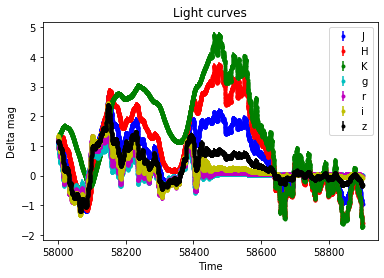

In [11]:
plt.errorbar(X, Jband[0], Jband[1], fmt='b.', label='J')
plt.errorbar(X, Hband[0], Hband[1], fmt='r.', label='H')
plt.errorbar(X, Kband[0], Kband[1], fmt='g.', label='K')
plt.errorbar(X, gband[0], gband[1], fmt='c.', label='g')
plt.errorbar(X, rband[0], rband[1], fmt='m.', label='r')
plt.errorbar(X, iband[0], iband[1], fmt='y.', label='i')
plt.errorbar(X, zband[0], zband[1], fmt='k.', label='z')
#plt.plot(X,Kband[0],label='K.')
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

In [12]:
#Select points at random for all bands to create reduced data
n_list = int(input("Enter the number of points: "))
the_list = list(range(len(X)))
ind = random.sample(the_list, n_list)

redX = X[ind]
np.savetxt('redobstime.txt',np.c_[redX],delimiter=',')

redJband = [Jband[0][ind],Jband[1][ind]]
np.savetxt('redJband.txt',np.c_[redJband[0],redJband[1]],delimiter=',')

redHband = [Hband[0][ind],Hband[1][ind]]
np.savetxt('redHband.txt',np.c_[redHband[0],redHband[1]],delimiter=',')

redKband = [Kband[0][ind],Kband[1][ind]]
np.savetxt('redKband.txt',np.c_[redKband[0],redKband[1]],delimiter=',')

redgband = [gband[0][ind],gband[1][ind]]
np.savetxt('redgband.txt',np.c_[redgband[0],redgband[1]],delimiter=',')

redrband = [rband[0][ind],rband[1][ind]]
np.savetxt('redrband.txt',np.c_[redrband[0],redrband[1]],delimiter=',')

rediband = [iband[0][ind],iband[1][ind]]
np.savetxt('rediband.txt',np.c_[rediband[0],rediband[1]],delimiter=',')

redzband = [zband[0][ind],zband[1][ind]]
np.savetxt('redzband.txt',np.c_[redzband[0],redzband[1]],delimiter=',')

Enter the number of points: 500


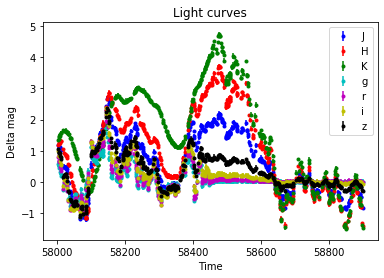

In [13]:
plt.errorbar(redX, redJband[0], redJband[1], fmt='b.', label='J')
plt.errorbar(redX, redHband[0], redHband[1], fmt='r.', label='H')
plt.errorbar(redX, redKband[0], redKband[1], fmt='g.', label='K')
plt.errorbar(redX, redgband[0], redgband[1], fmt='c.', label='g')
plt.errorbar(redX, redrband[0], redrband[1], fmt='m.', label='r')
plt.errorbar(redX, rediband[0], rediband[1], fmt='y.', label='i')
plt.errorbar(redX, redzband[0], redzband[1], fmt='k.', label='z')
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

In [ ]:
#TO DO
#save data as one file
#make random selection more evenly spaced

# These are tests to see if the values specified make sense

In [20]:
def transfertest(theta,tau):
    (sigma_DT, m_DT, theta_DT, 
     Jsigma_AD, Jm_AD, Jtheta_AD,
     Hsigma_AD, Hm_AD, Htheta_AD,
     Ksigma_AD, Km_AD, Ktheta_AD,
     gsigma_AD, gm_AD, gtheta_AD,
     rsigma_AD, rm_AD, rtheta_AD,
     isigma_AD, im_AD, itheta_AD,
     zsigma_AD, zm_AD, ztheta_AD,
     T, K_0, index)= theta

    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm
    Jwav = 1250.0
    Hwav = 1625.0
    Kwav = 2150.0
    #Sloan filters for ROSS2 in nm
    gwav = 475.4
    rwav = 620.4
    iwav = 769.8
    zwav = 966.5

    #Define constants 
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    #Peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = 4.967#h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    where_are_NaNsDT = np.isnan(lognorm_DT)
    lognorm_DT[where_are_NaNsDT] = 0.0
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*T)
    JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    #Dusty Torus transfer equation for H band
    Hb = h*c/(1e-9*Hwav*k*T)
    HBB = (1.0/( Hwav**5 * (np.exp(Hb) - 1.0) ))/BB_max
    HPsi_DT = HBB*lognorm_DT
    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*Kwav*k*T)
    KBB = (1.0/( Kwav**5 * (np.exp(Kb) - 1.0) ))/BB_max
    KPsi_DT = KBB*lognorm_DT
    #Dusty Torus transfer equation for g band
    gb = h*c/(1e-9*gwav*k*T)
    gBB = (1.0/( gwav**5 * (np.exp(gb) - 1.0) ))/BB_max
    gPsi_DT = gBB*lognorm_DT   
    #Dusty Torus transfer equation for r band
    rb = h*c/(1e-9*rwav*k*T)
    rBB = (1.0/( rwav**5 * (np.exp(rb) - 1.0) ))/BB_max
    rPsi_DT = rBB*lognorm_DT
    #Dusty Torus transfer equation for i band
    ib = h*c/(1e-9*iwav*k*T)
    iBB = (1.0/( iwav**5 * (np.exp(ib) - 1.0) ))/BB_max
    iPsi_DT = iBB*lognorm_DT
    #Dusty Torus transfer equation for z band
    zb = h*c/(1e-9*zwav*k*T)
    zBB = (1.0/( zwav**5 * (np.exp(zb) - 1.0) ))/BB_max
    zPsi_DT = zBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((np.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
    Jwhere_are_NaNs = np.isnan(Jlognorm_AD)
    Jlognorm_AD[Jwhere_are_NaNs] = 0.0
    JPsi_AD = Jpowr*Jlognorm_AD
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0*(Hwav/wav_0)**(index)    
    Hexp_AD = -((np.log((tau-Htheta_AD)/Hm_AD))**2/(2*Hsigma_AD**2))
    Hfront_AD = 1.0/((tau-Htheta_AD)*Hsigma_AD*np.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*np.exp(Hexp_AD)
    Hwhere_are_NaNs = np.isnan(Hlognorm_AD)
    Hlognorm_AD[Hwhere_are_NaNs] = 0.0
    HPsi_AD = Hpowr*Hlognorm_AD
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(Kwav/wav_0)**(index)    
    Kexp_AD = -((np.log((tau-Ktheta_AD)/Km_AD))**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*np.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*np.exp(Kexp_AD)
    Kwhere_are_NaNs = np.isnan(Klognorm_AD)
    Klognorm_AD[Kwhere_are_NaNs] = 0.0
    KPsi_AD = Kpowr*Klognorm_AD
    #Accretion Disk transfer equation for the g band
    gpowr = K_0*(gwav/wav_0)**(index)    
    gexp_AD = -((np.log((tau-gtheta_AD)/gm_AD))**2/(2*gsigma_AD**2))
    gfront_AD = 1.0/((tau-gtheta_AD)*gsigma_AD*np.sqrt(2*np.pi))
    glognorm_AD = gfront_AD*np.exp(gexp_AD)
    gwhere_are_NaNs = np.isnan(glognorm_AD)
    glognorm_AD[gwhere_are_NaNs] = 0.0
    gPsi_AD = gpowr*glognorm_AD
    #Accretion Disk transfer equation for the r band
    rpowr = K_0*(rwav/wav_0)**(index)    
    rexp_AD = -((np.log((tau-rtheta_AD)/rm_AD))**2/(2*rsigma_AD**2))
    rfront_AD = 1.0/((tau-rtheta_AD)*rsigma_AD*np.sqrt(2*np.pi))
    rlognorm_AD = rfront_AD*np.exp(rexp_AD)
    rwhere_are_NaNs = np.isnan(rlognorm_AD)
    rlognorm_AD[rwhere_are_NaNs] = 0.0
    rPsi_AD = rpowr*rlognorm_AD
    #Accretion Disk transfer equation for the i band
    ipowr = K_0*(iwav/wav_0)**(index)    
    iexp_AD = -((np.log((tau-itheta_AD)/im_AD))**2/(2*isigma_AD**2))
    ifront_AD = 1.0/((tau-itheta_AD)*isigma_AD*np.sqrt(2*np.pi))
    ilognorm_AD = ifront_AD*np.exp(iexp_AD)
    iwhere_are_NaNs = np.isnan(ilognorm_AD)
    ilognorm_AD[iwhere_are_NaNs] = 0.0
    iPsi_AD = ipowr*ilognorm_AD
    #Accretion Disk transfer equation for the z band
    zpowr = K_0*(zwav/wav_0)**(index)    
    zexp_AD = -((np.log((tau-ztheta_AD)/zm_AD))**2/(2*zsigma_AD**2))
    zfront_AD = 1.0/((tau-ztheta_AD)*zsigma_AD*np.sqrt(2*np.pi))
    zlognorm_AD = zfront_AD*np.exp(zexp_AD)
    zwhere_are_NaNs = np.isnan(zlognorm_AD)
    zlognorm_AD[zwhere_are_NaNs] = 0.0
    zPsi_AD = zpowr*zlognorm_AD
    
    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Htransfer = HPsi_DT + HPsi_AD
    Ktransfer = KPsi_DT + KPsi_AD
    gtransfer = gPsi_DT + gPsi_AD
    rtransfer = rPsi_DT + rPsi_AD
    itransfer = iPsi_DT + iPsi_AD
    ztransfer = zPsi_DT + zPsi_AD
    
    plt.plot(tau,Jtransfer,'b', label='J')
    plt.plot(tau,Htransfer,'r', label='H')
    plt.plot(tau,Ktransfer,'g', label='K')
    plt.plot(tau,gtransfer,'c', label='g')
    plt.plot(tau,rtransfer,'m', label='r')
    plt.plot(tau,itransfer,'y', label='i')
    plt.plot(tau,ztransfer,'k', label='z')
    #plt.plot(tau,lognorm_DT,'k',label='DT')
    plt.title('Light curves')
    plt.xlabel('Time')
    plt.ylabel('Delta mag')
    plt.legend()
    
    return [Jtransfer,Htransfer,Ktransfer,gtransfer,rtransfer,itransfer,ztransfer]

[array([0.        , 0.00274568, 0.0065159 , ..., 0.04429832, 0.04424159,
        0.04418477]),
 array([0.        , 0.0002179 , 0.00086251, ..., 0.07417957, 0.07408452,
        0.07398933]),
 array([0.00000000e+00, 1.48467878e-07, 2.23513703e-06, ...,
        8.63444632e-02, 8.62384069e-02, 8.61321920e-02]),
 array([0.        , 0.06266962, 0.06878686, ..., 0.00061846, 0.00061828,
        0.00061811]),
 array([0.        , 0.05354093, 0.06424453, ..., 0.00141553, 0.00141468,
        0.00141382]),
 array([0.        , 0.03364337, 0.04613231, ..., 0.00475642, 0.00475152,
        0.00474661]),
 array([0.        , 0.01021689, 0.01798786, ..., 0.01674979, 0.01672938,
        0.01670894])]

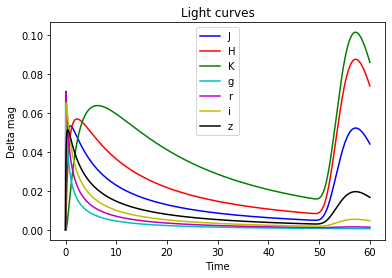

In [21]:
thetatest=(0.4,12.0,47.0, 
     1.80,24.62,0.0,
     1.57,26.61,0.0,
     1.23,28.66,0.0,
     2.4,11.68,0.0,
     2.31,14.34,0.0,
     2.18,17.13,0.0,
     1.99,22.55,0.0,
     1456.0, 1.0, 1.5)

transfertest(thetatest,tau)